In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
# 1. Load Data
try:
    df = pd.read_csv('/content/Superstore.csv', encoding='windows-1252')
except:
    df = pd.read_csv('/content/Superstore.csv', encoding='utf-8')

# Display basic info
print("Data Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 1

In [3]:
# 2. Preprocessing & Feature Engineering
# Grouping by Customer to create a customer-level dataset
# We will use Sales (Monetary), Order ID count (Frequency), and Profit
customer_df = df.groupby('Customer ID').agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Quantity': 'sum',
    'Order ID': 'nunique'
}).reset_index()

customer_df.columns = ['Customer ID', 'Total_Sales', 'Total_Profit', 'Total_Quantity', 'Frequency']

# Check for outliers or missing values (simple check)
print("\nCustomer Data Description:")
print(customer_df.describe())

# Standardize the data
scaler = StandardScaler()
features = ['Total_Sales', 'Total_Profit', 'Total_Quantity', 'Frequency']
df_scaled = scaler.fit_transform(customer_df[features])


Customer Data Description:
        Total_Sales  Total_Profit  Total_Quantity   Frequency
count    793.000000    793.000000      793.000000  793.000000
mean    2896.848500    361.156396       47.759142    6.316520
std     2628.670117    894.261812       24.842915    2.550885
min        4.833000  -6626.389500        2.000000    1.000000
25%     1146.050000     36.613100       30.000000    5.000000
50%     2256.394000    227.833800       44.000000    6.000000
75%     3785.276000    560.007800       63.000000    8.000000
max    25043.050000   8981.323900      150.000000   17.000000


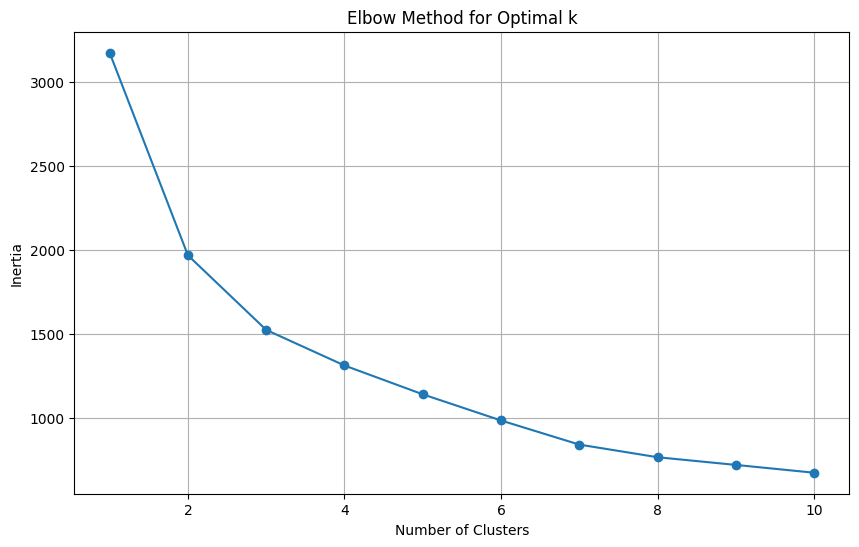

In [4]:
# Kenapa KMeans ? Algoritma yang efisien dan mudah diinterpretasikan untuk segmentasi pasar.
# 3. Finding Optimal K (Elbow Method)
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [5]:
# 4. Apply K-Means
# Based on typical retail patterns, k=4 is often a good starting point (e.g., Low, Medium, High, VIP/Outlier)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_df['Cluster'] = kmeans.fit_predict(df_scaled)

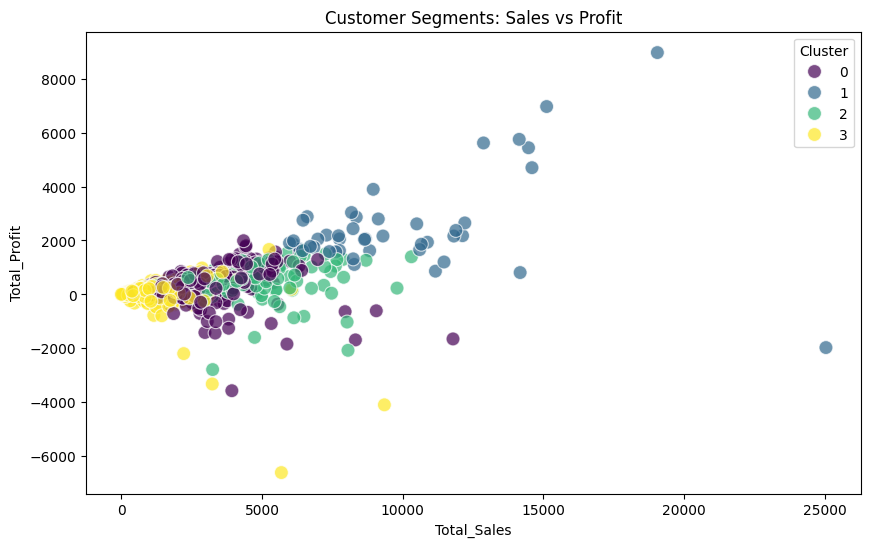

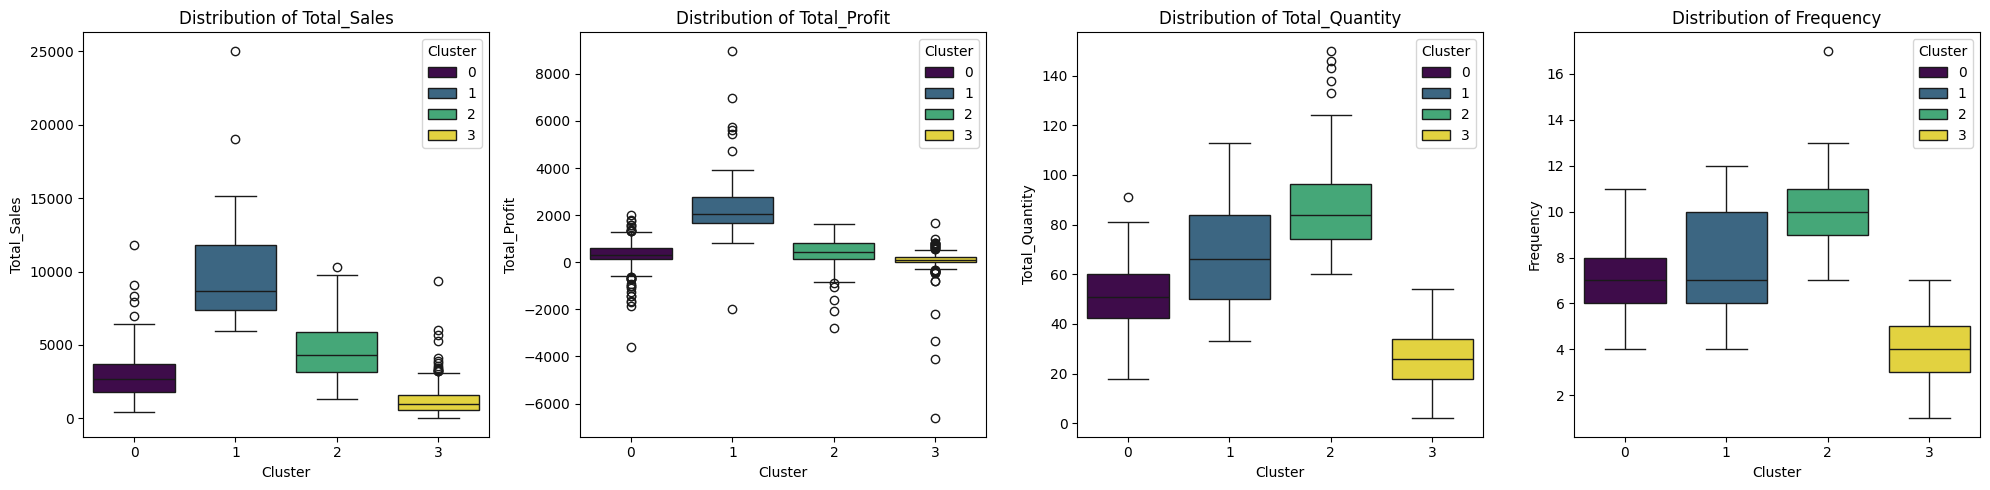

In [6]:
# 5. Visualization

# A. Scatter Plot: Sales vs Profit (Common business view)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_df, x='Total_Sales', y='Total_Profit', hue='Cluster', palette='viridis', s=100, alpha=0.7)
plt.title('Customer Segments: Sales vs Profit')
plt.show()

# B. Boxplots for Interpretation
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, col in enumerate(features):
    sns.boxplot(x='Cluster', y=col, data=customer_df, ax=axes[i], hue='Cluster', palette='viridis')
    axes[i].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [7]:
# 6. Interpretation Summary
cluster_summary = customer_df.groupby('Cluster')[features].mean().reset_index()
cluster_counts = customer_df['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Count']
cluster_summary = cluster_summary.merge(cluster_counts, on='Cluster')

print("\nCluster Summary (Mean Values):")
print(cluster_summary)


Cluster Summary (Mean Values):
   Cluster  Total_Sales  Total_Profit  Total_Quantity  Frequency  Count
0        0  2874.505417    328.128142       51.235650   7.018127    331
1        1  9951.135073   2502.723953       67.977778   7.800000     45
2        2  4583.976467    421.793146       87.070175   9.912281    114
3        3  1238.828950     56.368350       26.168317   3.976898    303


In [ ]:
# Cluster 0 – “Standard Customers”
# Ini adalah pelanggan “utama” yang memberi kontribusi stabil pada toko

# Cluster 1 – “High Value / VIP Customers”
# - Memiliki Total_Sales dan Total_Profit tertinggi, serta frekuensi belanja di atas rata-rata.
# Pelanggan ini sangat penting untuk dipertahankan (loyalty program, voucher khusus, dsb).

# Cluster 2 – “Low Spender / Occasional Buyers”
# - Biasanya hanya belanja sesekali dengan nilai kecil.
# - Potensi: bisa jadi target promosi untuk mendorong peningkatan frekuensi belanja.

# Cluster 3 – “Loss Makers / Discount Hunters”
# - Indikasi bahwa pelanggan ini sering membeli barang diskon besar atau produk dengan margin profit kecil.
# - Strategi: evaluasi kebijakan diskon dan paket promosi agar pelanggan ini tetap dilayani tapi dengan margin yang lebih sehat.